# 02 网络拓扑与 ABM 验证

目标：在复杂网络上验证理论临界点 $r_c$ 与分岔，并对比对称/非对称两种实现。

约定：`k_avg` 表示每个体每步采样的信号数量；当 ABM 使用 `sample_mode="fixed"` 时，`k_avg=sample_n`；当使用 `sample_mode="degree"` 时，`k_avg≈avg_degree`。


In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import theory, NetworkConfig, NetworkAgentModel

output_dir = ROOT / "outputs"
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / "data"
fig_dir = output_dir / "figs" / "fig2"
data_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

def fmt_path(path: Path) -> str:
    try:
        return path.relative_to(ROOT).as_posix()
    except ValueError:
        return path.as_posix()

phi, theta = 0.54, 0.46
TARGET_SAMPLE_N = 50  # 理论/模拟统一采样数
n_m, n_w = 10, 5

chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = float(theory.calculate_rc(n_m, n_w, chi_ref))
print(f"Theory Reference: chi={chi_ref:.4f}, rc={rc_ref:.4f}, sample_n={TARGET_SAMPLE_N}")


Theory Reference: chi=9.5962, rc=0.7533, sample_n=50


In [3]:
# 理论 r_c 对比：k_avg=50（与 sample_n 对齐） vs k_avg=1999（高采样上限示例）
chi_50 = theory.calculate_chi(phi, theta, k_avg=50)
rc_50 = float(theory.calculate_rc(n_m, n_w, chi_50))
chi_1999 = theory.calculate_chi(phi, theta, k_avg=1999)
rc_1999 = float(theory.calculate_rc(n_m, n_w, chi_1999))
print(f"Theory r_c (k_avg=50):   {rc_50:.4f}")
print(f"Theory r_c (k_avg=1999): {rc_1999:.4f}")
if rc_1999 > 1:
    print("提示：r_c>1 表示在 r∈[0,1] 内不会越过临界点（该 k_avg 口径下）。")


Theory r_c (k_avg=50):   0.7533
Theory r_c (k_avg=1999): 1.7859
提示：r_c>1 表示在 r∈[0,1] 内不会越过临界点（该 k_avg 口径下）。



## 02a 对称模式 (Symmetric)


[sym] Loaded cache: outputs/data/rq_a_scan_sym_k50_samp50_beta0.0_seeds10_steps300_v2.npz


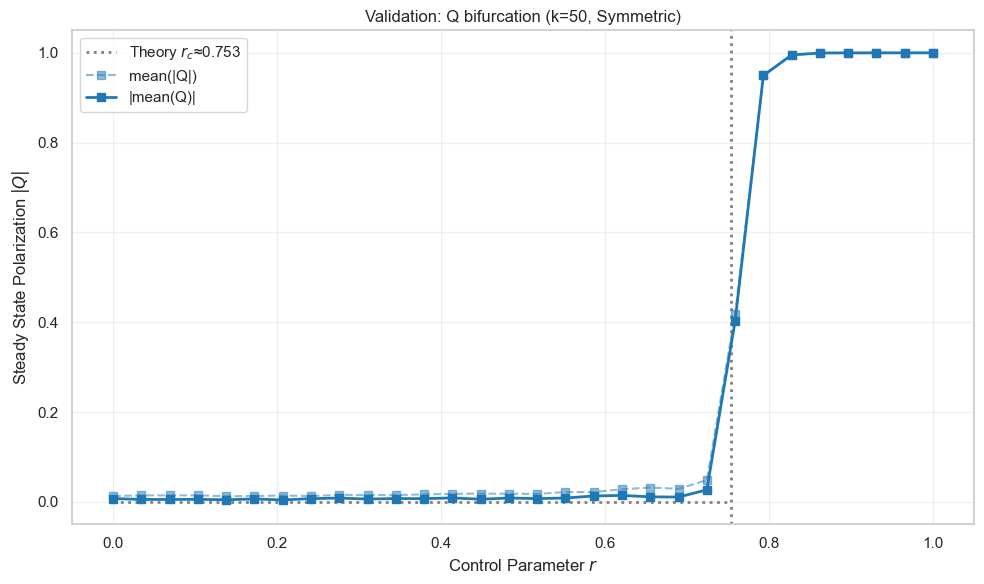

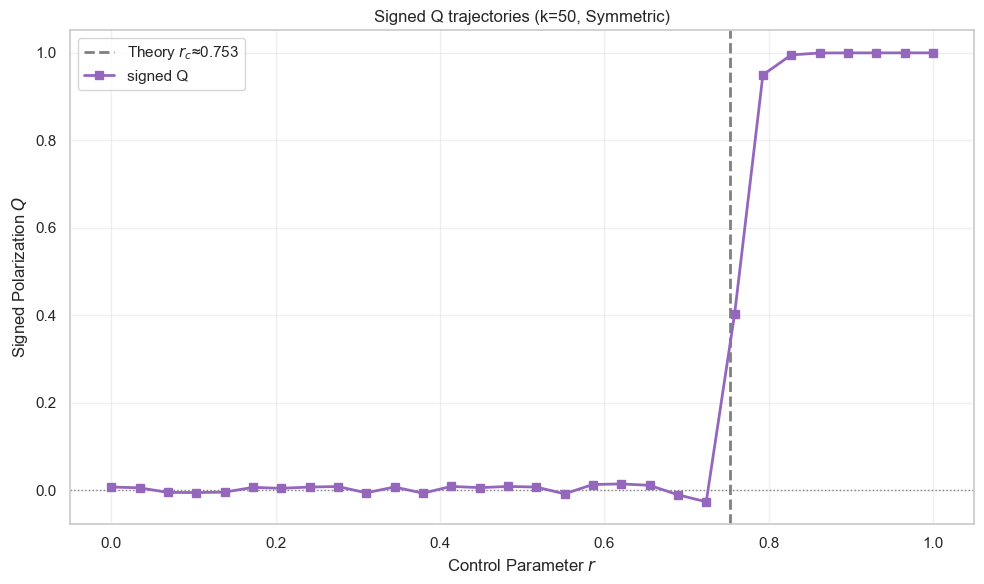

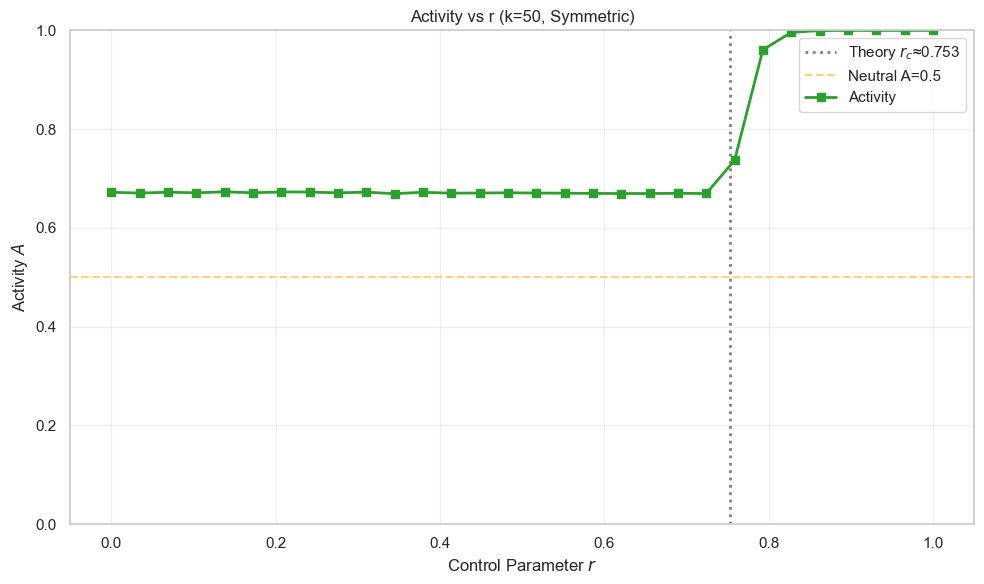

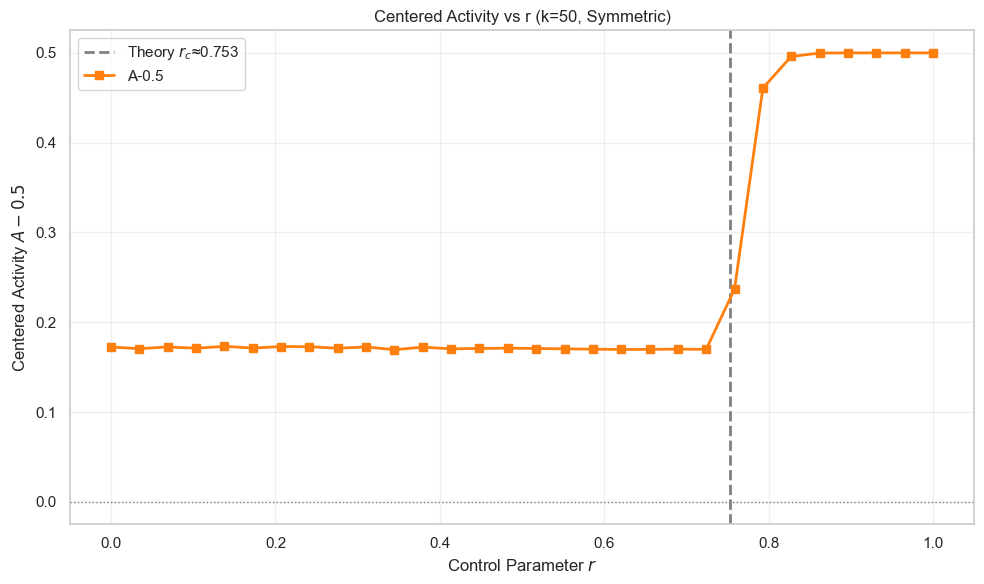

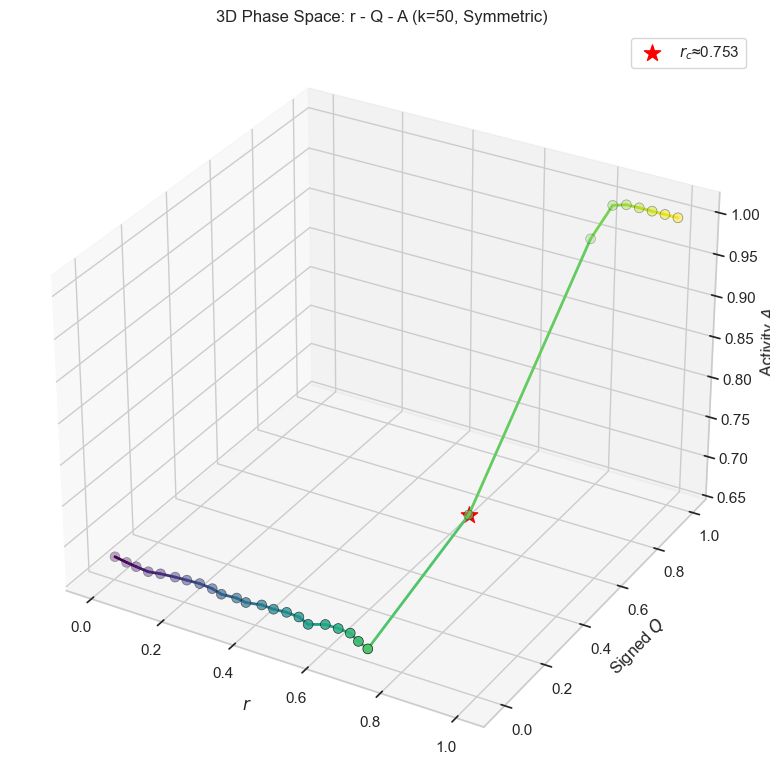

In [5]:
# 共用：ABM 扫描与绘图（对称 / 非对称）
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 实验参数（两种模式共用）
N = 500
r_scan = np.linspace(0, 1.0, 30)
beta_fixed = 0.0  # 保持无耦合，验证理论基准
seeds = list(range(10))
steps = 300

topology_setups = [
    {"k": 50, "label": "k=50 (Dense)"},
]


def run_abm_scan(symmetric_mode: bool, mode_tag: str):
    # 对给定模式跑 r 扫描，返回 r_scan 与结果字典
    cache_name = (
        f"rq_a_scan_{mode_tag}_k{TARGET_SAMPLE_N}_samp{TARGET_SAMPLE_N}_"
        f"beta{beta_fixed}_seeds{len(seeds)}_steps{steps}_v2.npz"
    )
    cache_path = data_dir / cache_name

    results = {
        cfg["label"]: {
            "abs_mean": [],
            "mean_abs": [],
            "signed_mean": [],
            "a_mean": [],
            "a_signed": [],
        }
        for cfg in topology_setups
    }

    if cache_path.exists():
        loaded = np.load(cache_path)
        r_vals = loaded["r_scan"]
        res = results[topology_setups[0]["label"]]
        for key in ["abs_mean", "mean_abs", "signed_mean", "a_mean", "a_signed"]:
            res[key] = loaded[key]
        print(f"[{mode_tag}] Loaded cache: {fmt_path(cache_path)}")
        return r_vals, results

    print(f"[{mode_tag}] Simulating ABM scans...")
    for cfg in topology_setups:
        k = cfg["k"]
        label = cfg["label"]

        q_mean_abs_list, q_abs_mean_list, q_signed_list = [], [], []
        a_mean_list, a_signed_list = [], []

        for r in r_scan:
            q_ma_seeds, q_am_seeds, q_signed_seeds = [], [], []
            a_seeds, a_signed_seeds = [], []

            for seed in seeds:
                net_cfg = NetworkConfig(
                    n=N,
                    avg_degree=k,
                    model="er",
                    beta=beta_fixed,
                    r=r,
                    n_m=n_m,
                    n_w=n_w,
                    phi=phi,
                    theta=theta,
                    seed=seed,
                    init_state="medium",
                    sample_mode="fixed",
                    sample_n=TARGET_SAMPLE_N,
                    symmetric_mode=symmetric_mode,
                )
                model = NetworkAgentModel(net_cfg)
                _, q_traj, a_traj = model.run(steps=steps, record_interval=50)

                steady_q = q_traj[-5:]
                steady_a = a_traj[-5:]
                q_ma_seeds.append(np.mean(np.abs(steady_q)))
                q_am_seeds.append(np.abs(np.mean(steady_q)))
                q_signed_seeds.append(np.mean(steady_q))
                a_seeds.append(np.mean(steady_a))
                a_signed_seeds.append(np.mean(steady_a - 0.5))

            q_mean_abs_list.append(np.mean(q_ma_seeds))
            q_abs_mean_list.append(np.mean(q_am_seeds))

            # 对称性破缺处理：多数投票确定符号，避免不同 seeds 相互抵消
            signs = np.sign(q_signed_seeds)
            majority_sign = np.sign(np.sum(signs)) if np.sum(signs) != 0 else 1.0
            q_signed_list.append(majority_sign * np.mean(np.abs(q_signed_seeds)))

            a_mean_list.append(np.mean(a_seeds))
            a_signed_list.append(np.mean(a_signed_seeds))

        res = results[label]
        res["mean_abs"] = np.array(q_mean_abs_list)
        res["abs_mean"] = np.array(q_abs_mean_list)
        res["signed_mean"] = np.array(q_signed_list)
        res["a_mean"] = np.array(a_mean_list)
        res["a_signed"] = np.array(a_signed_list)

    res0 = results[topology_setups[0]["label"]]
    np.savez(
        cache_path,
        r_scan=r_scan,
        abs_mean=res0["abs_mean"],
        mean_abs=res0["mean_abs"],
        signed_mean=res0["signed_mean"],
        a_mean=res0["a_mean"],
        a_signed=res0["a_signed"],
    )
    print(f"[{mode_tag}] Saved cache: {fmt_path(cache_path)}")
    return r_scan, results


def plot_abm_results(
    r_vals,
    results,
    mode_tag: str,
    title_tag: str,
    color_main: str = "tab:blue",
    cmap: str = "viridis",
    star_color: str = "red",
):
    # 复用绘图：Fig2a-2e
    label = topology_setups[0]["label"]
    res = results[label]

    # Fig2a: |Q| 分岔图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=fr"Theory $r_c$≈{rc_ref:.3f}")
    ax.hlines(0, 0, rc_ref, colors="gray", linestyles=":", linewidth=2)
    ax.plot(r_vals, res["mean_abs"], "s--", color=color_main, alpha=0.5, label="mean(|Q|)")
    ax.plot(r_vals, res["abs_mean"], "s-", color=color_main, linewidth=2, label="|mean(Q)|")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Steady State Polarization $|Q|$")
    ax.set_title(f"Validation: Q bifurcation (k=50, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2a_r_q_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2b: Signed Q
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axhline(0, color="gray", linestyle=":", linewidth=1)
    ax.axvline(rc_ref, color="gray", linestyle="--", linewidth=2, label=fr"Theory $r_c$≈{rc_ref:.3f}")
    ax.plot(r_vals, res["signed_mean"], "s-", color="tab:purple", linewidth=2, label="signed Q")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Signed Polarization $Q$")
    ax.set_title(f"Signed Q trajectories (k=50, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2b_signed_q_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2c: Activity A
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=fr"Theory $r_c$≈{rc_ref:.3f}")
    ax.axhline(0.5, color="orange", linestyle="--", alpha=0.5, label="Neutral A=0.5")
    ax.plot(r_vals, res["a_mean"], "s-", color="tab:green", linewidth=2, label="Activity")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Activity $A$")
    ax.set_title(f"Activity vs r (k=50, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2c_activity_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2d: Centered Activity (A-0.5)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axhline(0, color="gray", linestyle=":", linewidth=1)
    ax.axvline(rc_ref, color="gray", linestyle="--", linewidth=2, label=fr"Theory $r_c$≈{rc_ref:.3f}")
    ax.plot(r_vals, res["a_signed"], "s-", color="tab:orange", linewidth=2, label="A-0.5")
    ax.set_xlabel("Control Parameter $r$")
    ax.set_ylabel("Centered Activity $A-0.5$")
    ax.set_title(f"Centered Activity vs r (k=50, {title_tag})")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2d_centered_activity_{mode_tag}.png", dpi=200)
    plt.show()

    # Fig2e: 3D 相图 r - Q - A
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    cm = getattr(plt.cm, cmap)
    colors = cm(np.linspace(0, 1, len(r_vals)))
    for i in range(len(r_vals) - 1):
        ax.plot(
            r_vals[i : i + 2],
            res["signed_mean"][i : i + 2],
            res["a_mean"][i : i + 2],
            color=colors[i],
            linewidth=2,
        )
    ax.scatter(
        r_vals,
        res["signed_mean"],
        res["a_mean"],
        c=r_vals,
        cmap=cmap,
        s=50,
        edgecolor="k",
        linewidth=0.5,
    )
    rc_idx = np.argmin(np.abs(r_vals - float(rc_ref)))
    ax.scatter(
        [r_vals[rc_idx]],
        [res["signed_mean"][rc_idx]],
        [res["a_mean"][rc_idx]],
        color=star_color,
        s=150,
        marker="*",
        label=fr"$r_c$≈{rc_ref:.3f}",
        zorder=10,
    )
    ax.set_xlabel("$r$")
    ax.set_ylabel("Signed $Q$")
    ax.set_zlabel("Activity $A$")
    ax.set_title(f"3D Phase Space: r - Q - A (k=50, {title_tag})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(fig_dir / f"fig2e_3d_r_q_a_{mode_tag}.png", dpi=200)
    plt.show()


# 运行对称模式
r_sym, res_sym = run_abm_scan(symmetric_mode=True, mode_tag="sym")
plot_abm_results(
    r_sym,
    res_sym,
    mode_tag="sym",
    title_tag="Symmetric",
    color_main="tab:blue",
    cmap="viridis",
    star_color="red",
)



## 02b 非对称模式 (Asymmetric)


[asym] Loaded cache: outputs/data/rq_a_scan_asym_k50_samp50_beta0.0_seeds10_steps300_v2.npz


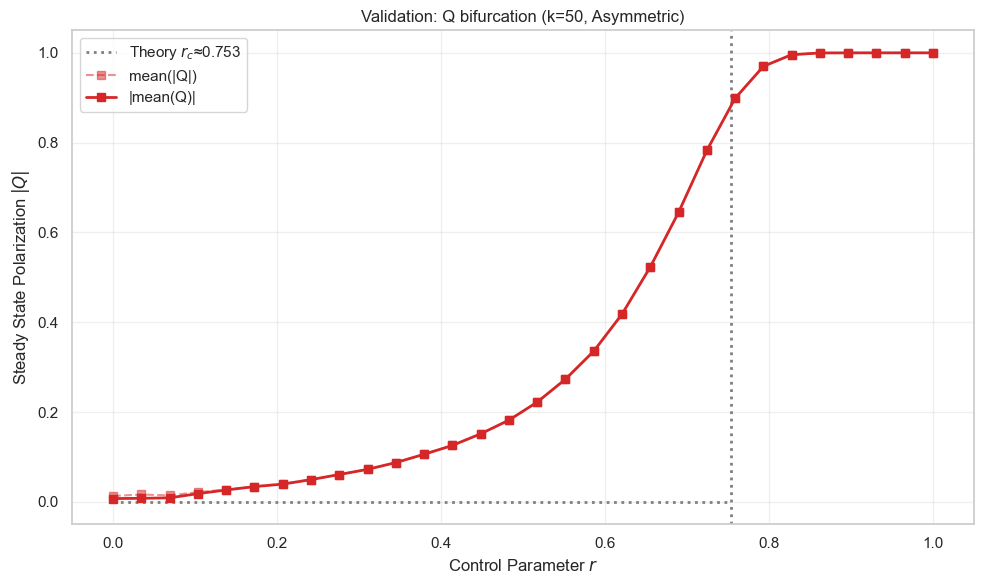

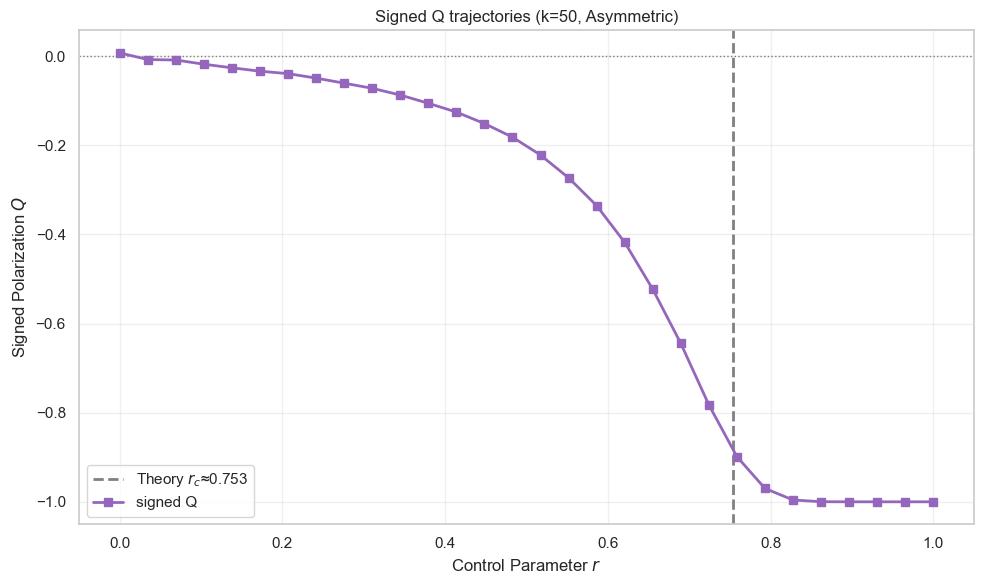

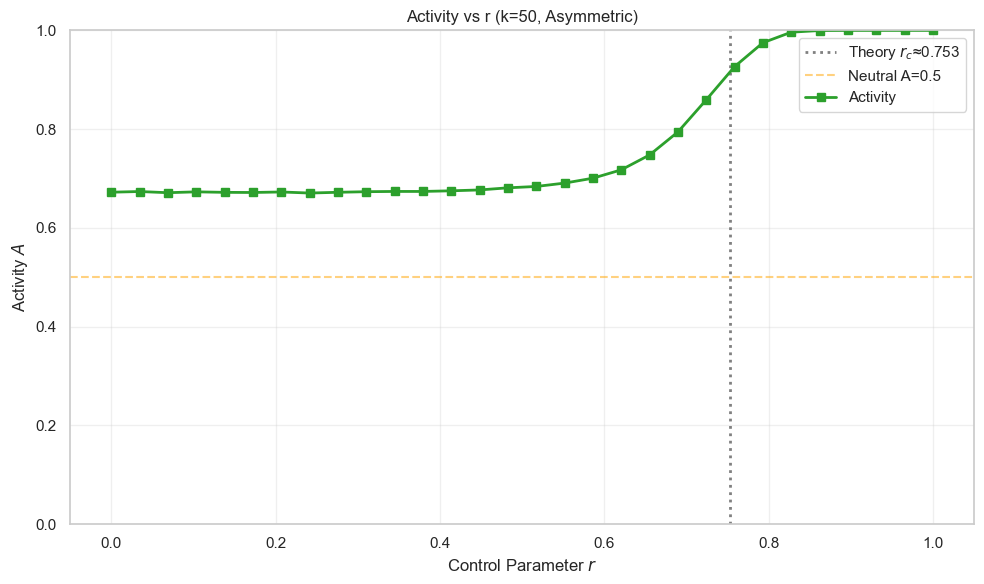

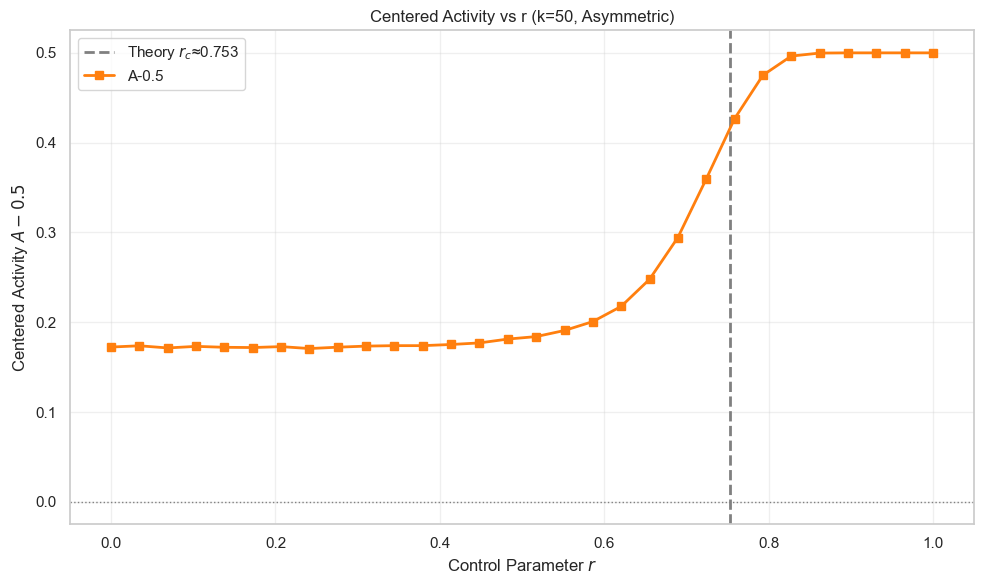

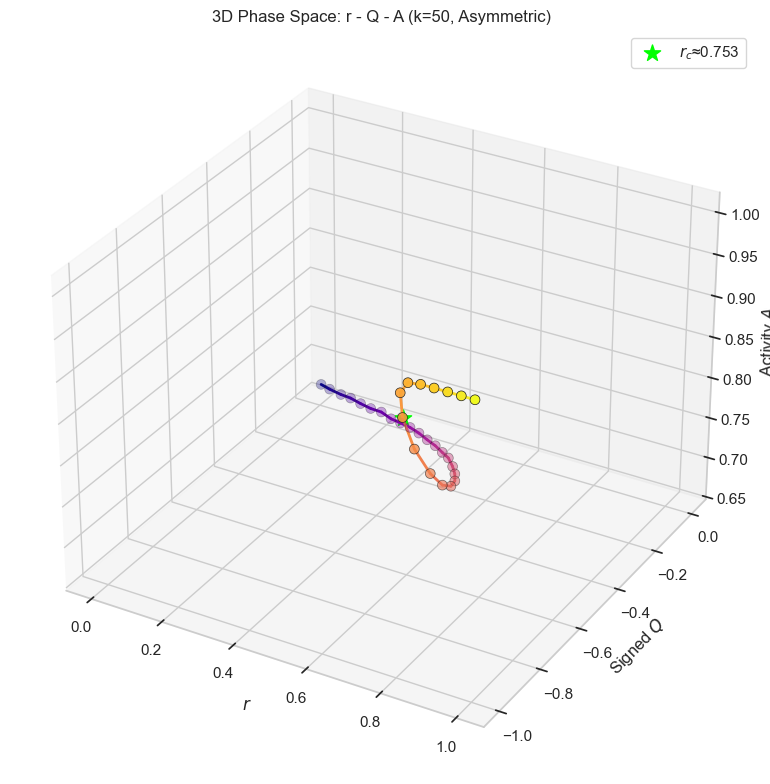

In [4]:
# 运行非对称模式（复用上一个 cell 的函数）
r_asym, res_asym = run_abm_scan(symmetric_mode=False, mode_tag="asym")
plot_abm_results(
    r_asym,
    res_asym,
    mode_tag="asym",
    title_tag="Asymmetric",
    color_main="tab:red",
    cmap="plasma",
    star_color="lime",
)



## 附录：有限尺寸效应 (Finite-Size Scaling)

**目标**：验证随着系统规模 N 增大，模拟的 $r_c$ 趋近于理论预测值。


理论 rc = 0.7533
N=100: rc_est ≈ 0.763
N=200: rc_est ≈ 0.763
N=500: rc_est ≈ 0.763
N=1000: rc_est ≈ 0.737
N=2000: rc_est ≈ 0.763


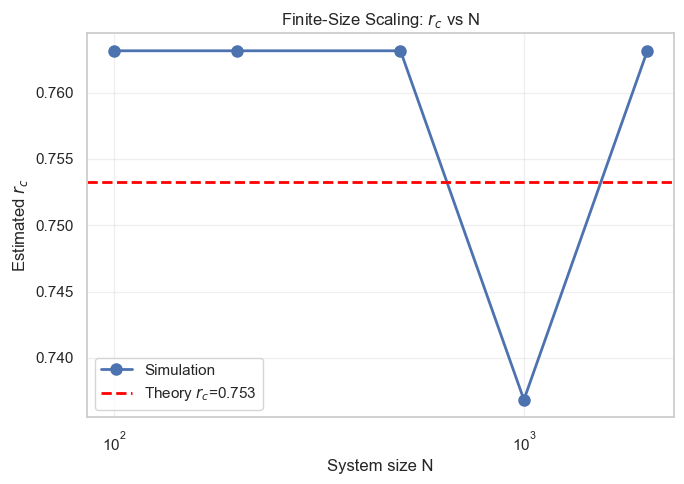

提示：rc_est 为阈值法粗估；若要检验 rc(N) 是否收敛到理论 0.753，建议加密 r 扫描并使用方差/自相关峰值等判据。


In [6]:
# 有限尺寸效应验证：N 扫描下的 r_c(N)
k_avg = TARGET_SAMPLE_N
seed = 42

chi = theory.calculate_chi(phi, theta, k_avg=k_avg)
rc_theory = float(theory.calculate_rc(n_m, n_w, chi))
print(f"理论 rc = {rc_theory:.4f}")

N_list = [100, 200, 500, 1000, 2000]
r_scan_fs = np.linspace(0.5, 1.0, 20)  # 聚焦于 rc 附近
rc_measured = []

for N in N_list:
    q_means = []
    for r in r_scan_fs:
        cfg = NetworkConfig(
            n=N,
            avg_degree=min(k_avg, N - 1),
            model="er",
            beta=0.0,
            r=r,
            n_m=n_m,
            n_w=n_w,
            phi=phi,
            theta=theta,
            seed=seed,
            init_state="medium",
            sample_mode="fixed",
            sample_n=min(k_avg, N - 1),
            symmetric_mode=True,
        )
        model = NetworkAgentModel(cfg)
        _, q_traj, _ = model.run(steps=300, record_interval=10)
        q_means.append(np.mean(np.abs(q_traj[-5:])))

    q_means = np.array(q_means)
    threshold = 0.1
    idx = np.where(q_means > threshold)[0]
    rc_est = r_scan_fs[idx[0]] if len(idx) > 0 else np.nan
    rc_measured.append(rc_est)
    print(f"N={N}: rc_est ≈ {rc_est:.3f}")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(N_list, rc_measured, "o-", markersize=8, linewidth=2, label="Simulation")
ax.axhline(rc_theory, color="red", linestyle="--", linewidth=2, label=f"Theory $r_c$={rc_theory:.3f}")
ax.set_xlabel("System size N")
ax.set_ylabel("Estimated $r_c$")
ax.set_title("Finite-Size Scaling: $r_c$ vs N")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale("log")
fig.tight_layout()
plt.show()

print(f"提示：rc_est 为阈值法粗估；若要检验 rc(N) 是否收敛到理论 {rc_theory:.3f}，建议加密 r 扫描并使用方差/自相关峰值等判据。")
